In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
from utils.data import load_tc_data
from utils.plot import make_cmap
import imageio
# from utils.metrics import calculate_fid
import xesmf as xe
import glob
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

# TODO: check which way the storms are rotating and how this is plotted - if using imshow it won't take into account
# the fact that mswep uses reverse latitude
# TODO: are the accumulated ones being plotted in the right places? like is it in the right order?

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title=False,levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False,cbar=False,cax=False,title_pos=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                                colour='black'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                                colour='black'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                                colour='black'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                                colour='black'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                                colour='black'
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                                colour='black'
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour,linewidth=2)
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        # ax.set_xticklabels(labelsize=20)
        # ax.set_yticklabels(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
                # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        
        if cbar == True:
                precip_cmap,precip_norm = make_cmap(high_vals=True)
                cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                # cbar.ax.tick_params(labelsize=8,width=0.5)
                cbar.ax.tick_params(labelsize=20)

        if (title != False) and (title_pos == False):
                ax.set_title(title,fontsize=26,pad=15)
        elif (title != False) and (title_pos != False):
                x,y = title_pos
                print(x)
                print(y)
                ax.text(x,y,title,fontsize=30)
        

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [3]:
def accumulated_rain(storm,meta,real,pred_gan,inputs,t=False,flip=True):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	# calculate lats and lons for storm
	lats,lons = tc_region(meta,storm,lat,lon)
	grid_x, grid_y = np.meshgrid(lons,lats)

	a = np.zeros((grid_y.shape))
	print('a shape',a.shape)
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	for i in storm:
		if t != False:
			if i > t:
				continue

		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		# accumulated_ds_input = accumulated_ds_input + ds_input_out

	return accumulated_ds,accumulated_ds_pred

In [4]:

real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')

hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)

In [5]:

valid_sids = list(dict.fromkeys(meta['sid']))

for sid in valid_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

extreme_valid_sids = list(dict.fromkeys(meta_extreme_valid['sid']))
for sid in extreme_valid_sids:
	indices = meta_extreme_valid.sid[meta_extreme_valid.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)


In [6]:
# get tracks
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [7]:
# Irene 2011233N15301 validation NA
# accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta,real,pred_gan,inputs)

meta_irene = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2011233N15301.csv')
irene_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2011233N15301.npy')[:,:,:,0]
irene_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2011233N15301.npy')[:,:,:,0]
irene_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2011233N15301.npy')[:,:,:,0]
sid_2011233N15301 = np.arange(len(irene_real[:,0,0]))
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta_irene,irene_real,irene_pred,irene_inputs,t=1)
storm_1 = '2011233N15301'

# storm_1 = '2011233N15301'
# get tracks
centre_lats_1 = tracks['lat'].loc[tracks['sid']==storm_1].reset_index(drop=True)
centre_lons_1 = tracks['lon'].loc[tracks['sid']==storm_1].reset_index(drop=True)
intensity_1 = tracks['sshs'].loc[tracks['sid']==storm_1].reset_index(drop=True)

lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
a shape (378, 278)


In [8]:

meta_irene = meta_irene.drop("Unnamed: 0", axis=1)
meta_irene = meta_irene.drop("Unnamed: 0.1", axis=1)
print(meta_irene)


              sid  centre_lat  centre_lon
0   2011233N15301     17.9000    -65.0000
1   2011233N15301     19.7000    -68.8000
2   2011233N15301     23.5000    -75.1000
3   2011233N15301     32.1000    -77.1000
4   2011233N15301     36.7000    -75.7000
5   2011233N15301     18.9000    -67.0000
6   2011233N15301     20.4000    -70.6000
7   2011233N15301     21.9000    -73.3000
8   2011233N15301     25.4000    -76.6000
9   2011233N15301     30.0000    -77.4000
10  2011233N15301     34.7000    -76.6000
11  2011233N15301     40.3000    -74.1000
12  2011233N15301     17.1853    -62.9918
13  2011233N15301     19.1224    -67.5228
14  2011233N15301     20.5498    -70.9151
15  2011233N15301     22.2623    -73.8306
16  2011233N15301     25.9739    -76.9547
17  2011233N15301     30.5650    -77.4870
18  2011233N15301     35.1074    -76.4792
19  2011233N15301     41.3249    -73.6950
20  2011233N15301     20.7000    -71.2000
21  2011233N15301     26.5000    -77.2000
22  2011233N15301     31.1000    -

In [10]:
# print(meta_irene)
# meta_irene = meta_irene.reset_index()
# print(meta_irene)
# meta_irene = meta_irene.drop("index", axis=1)
print(meta_irene)

              sid  centre_lat  centre_lon
0   2011233N15301     17.9000    -65.0000
1   2011233N15301     19.7000    -68.8000
2   2011233N15301     23.5000    -75.1000
3   2011233N15301     32.1000    -77.1000
4   2011233N15301     36.7000    -75.7000
5   2011233N15301     18.9000    -67.0000
6   2011233N15301     20.4000    -70.6000
7   2011233N15301     21.9000    -73.3000
8   2011233N15301     25.4000    -76.6000
9   2011233N15301     30.0000    -77.4000
10  2011233N15301     34.7000    -76.6000
11  2011233N15301     40.3000    -74.1000
12  2011233N15301     17.1853    -62.9918
13  2011233N15301     19.1224    -67.5228
14  2011233N15301     20.5498    -70.9151
15  2011233N15301     22.2623    -73.8306
16  2011233N15301     25.9739    -76.9547
17  2011233N15301     30.5650    -77.4870
18  2011233N15301     35.1074    -76.4792
19  2011233N15301     41.3249    -73.6950
20  2011233N15301     20.7000    -71.2000
21  2011233N15301     26.5000    -77.2000
22  2011233N15301     31.1000    -

[33 47 12 25  0 34 41 48  5 13 26  1 35 42 49  6 14 20 27 36 43 50  7 15
 28  2 37  8 16 21 29 38 44 51  9 17 22 30  3 39 45 52 10 18 23 31  4 40
 46 53 54 11 19 24 32]
[[[ 0.1875  0.1875  0.     ...  0.5     0.4375  0.5   ]
  [ 0.4375  0.4375  0.25   ...  0.375   0.375   0.375 ]
  [ 0.4375  0.4375  0.25   ...  0.375   0.375   0.375 ]
  ...
  [ 0.25    0.375   0.5    ...  0.      0.0625  0.    ]
  [ 0.5     0.625   0.4375 ...  0.      0.      0.    ]
  [ 0.3125  0.3125  0.375  ...  0.      0.      0.    ]]

 [[ 0.125   0.1875  0.1875 ...  1.5625  1.625   1.75  ]
  [ 0.125   0.1875  0.1875 ...  1.5625  1.625   1.5625]
  [ 0.25    0.3125  0.3125 ...  1.4375  1.4375  1.3125]
  ...
  [ 0.      0.      0.     ...  0.125   0.125   0.1875]
  [ 0.      0.      0.     ...  0.125   0.125   0.125 ]
  [ 0.      0.      0.     ...  0.125   0.125   0.125 ]]

 [[ 0.375   0.25    0.25   ...  1.6875  1.75    1.4375]
  [ 0.375   0.25    0.25   ...  1.625   1.6875  1.4375]
  [ 0.375   0.25    0.25   ... 

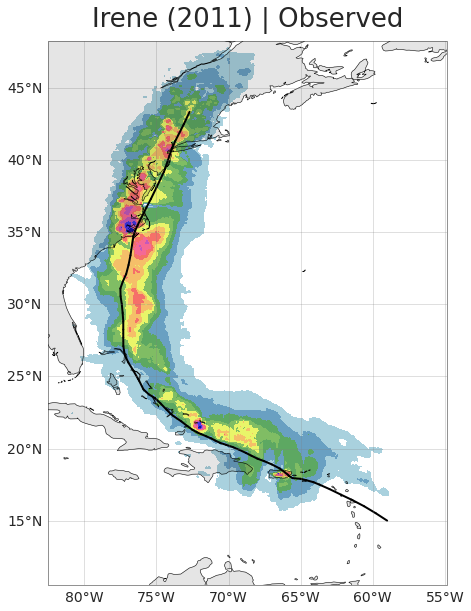

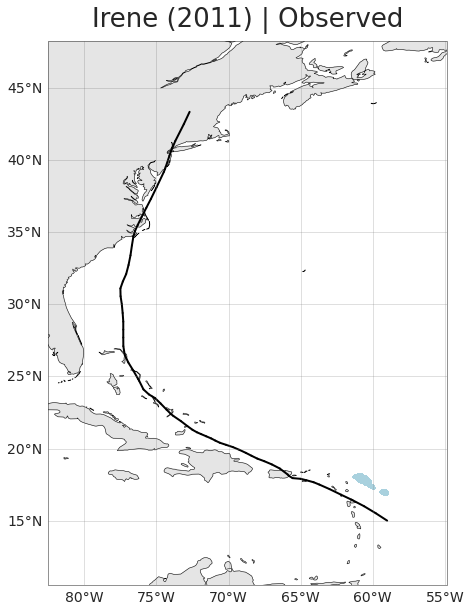

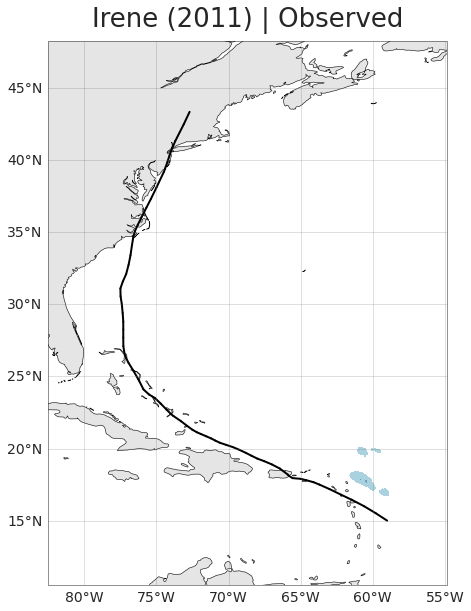

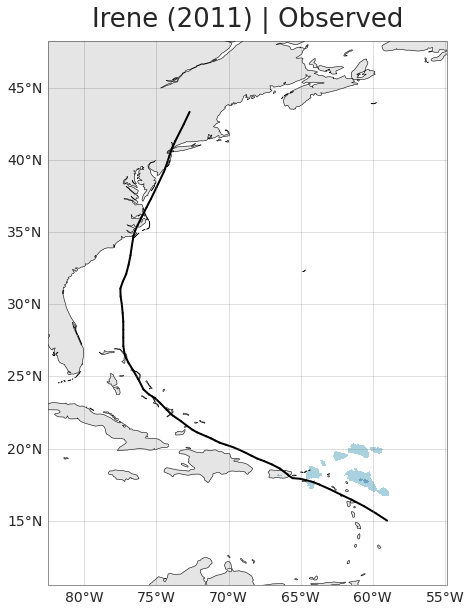

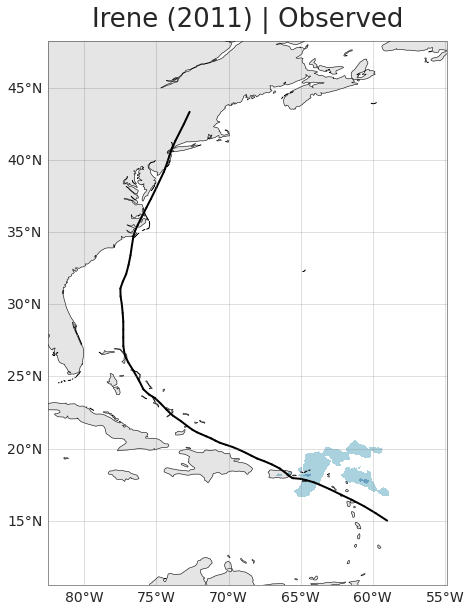

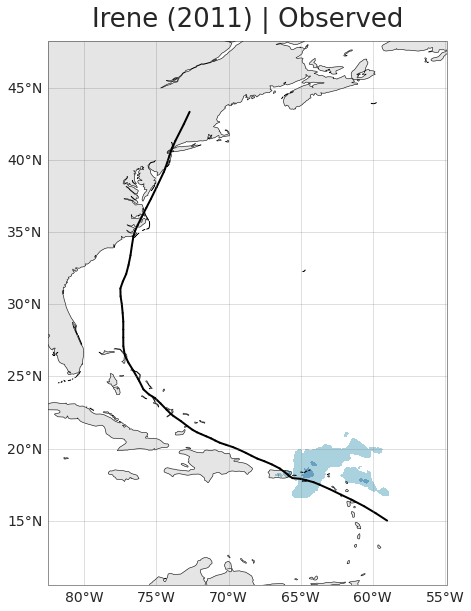

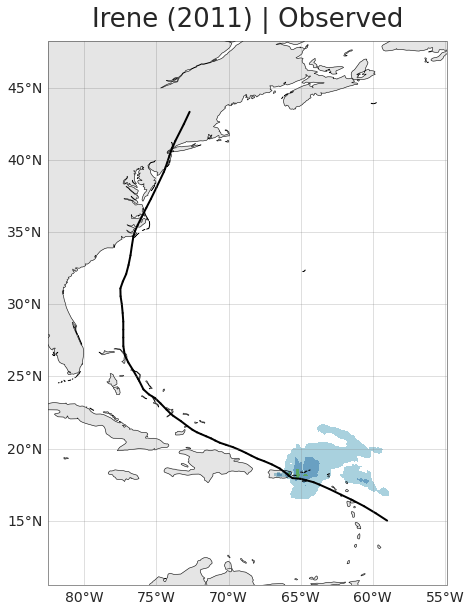

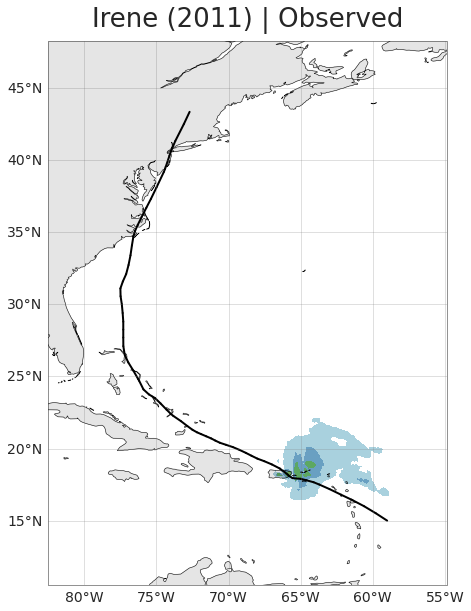

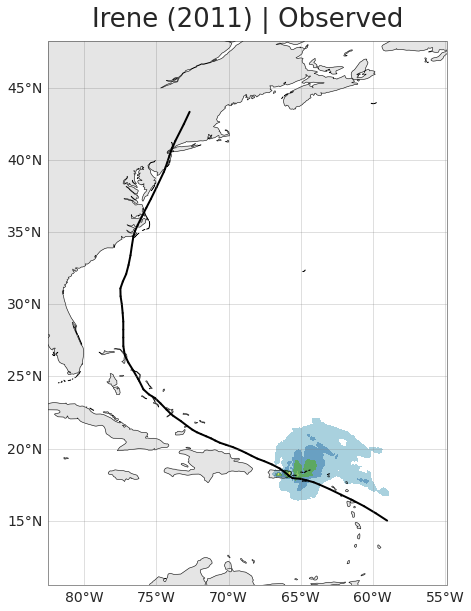

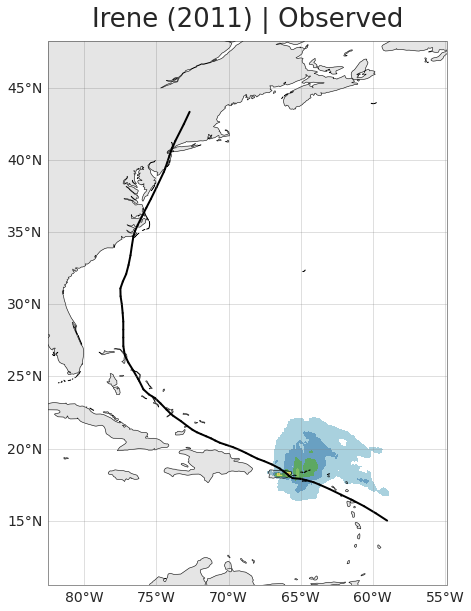

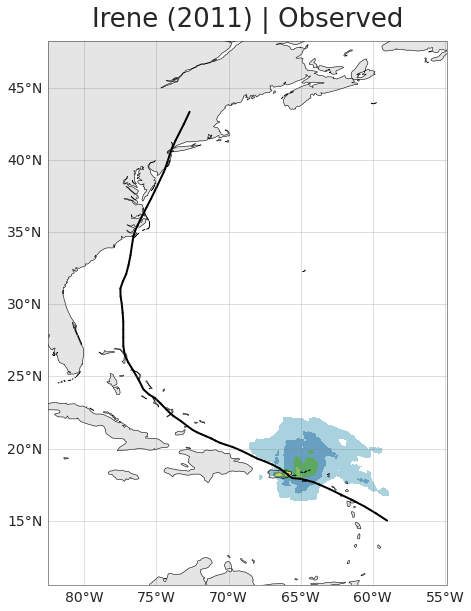

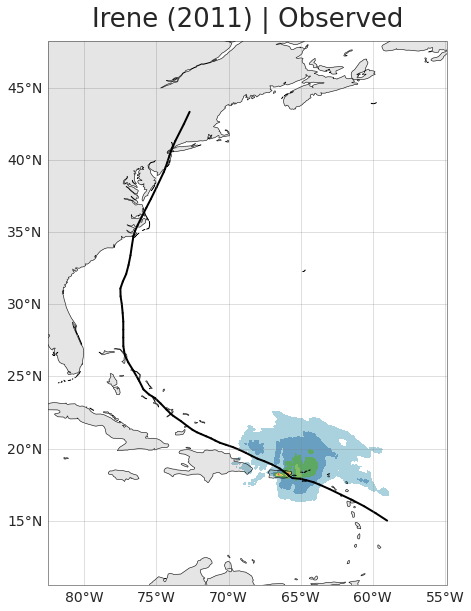

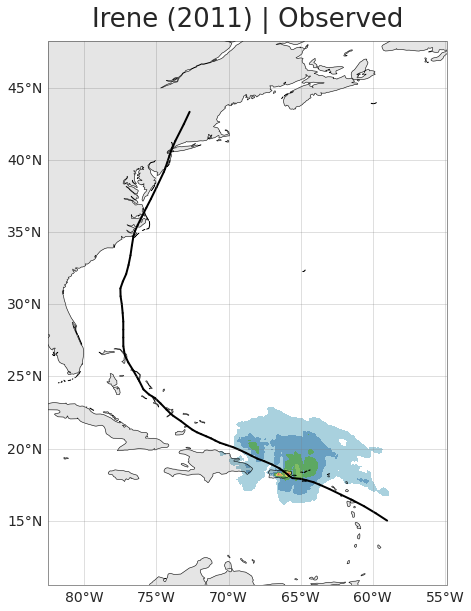

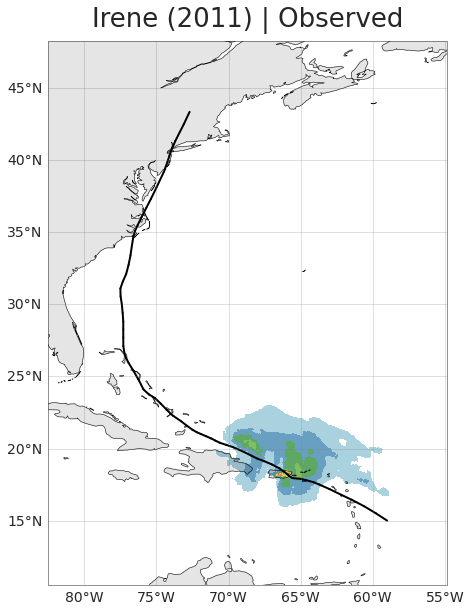

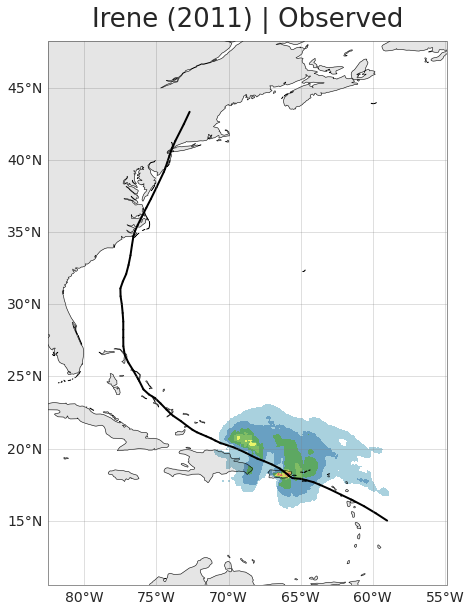

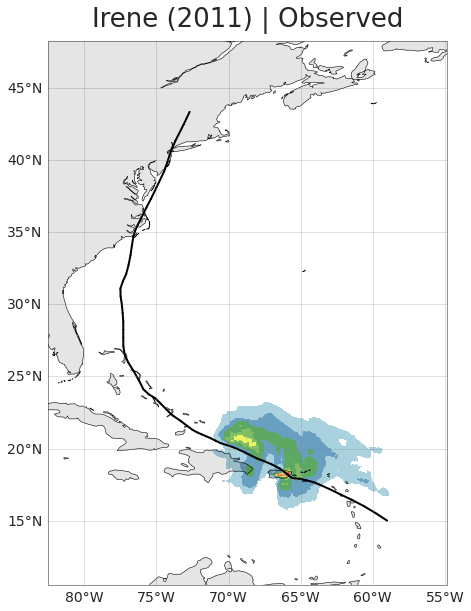

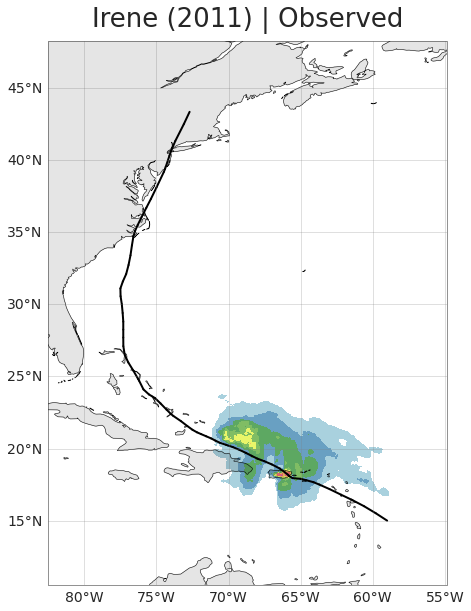

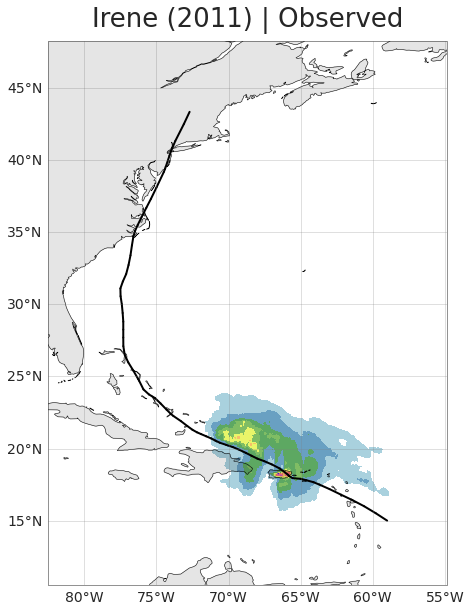

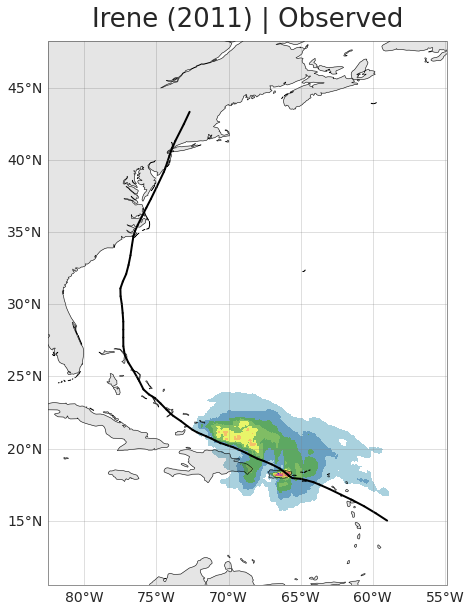

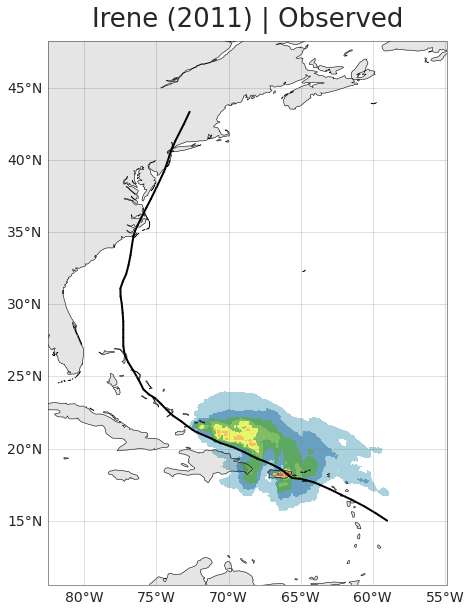

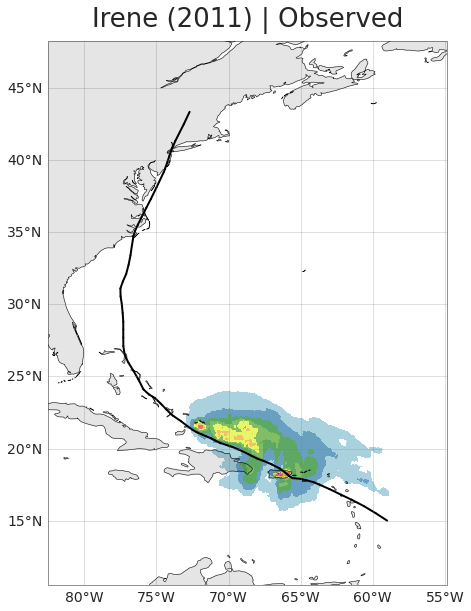

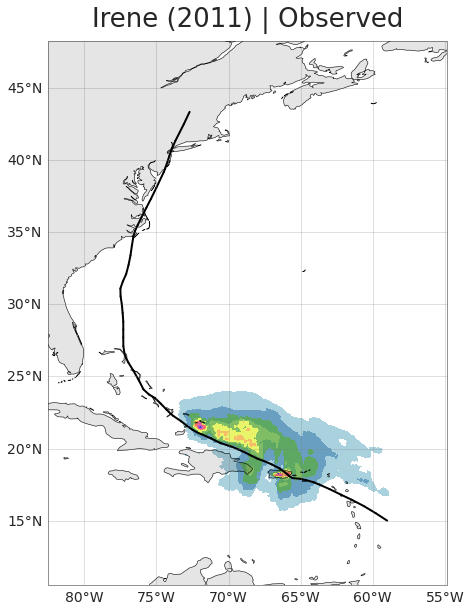

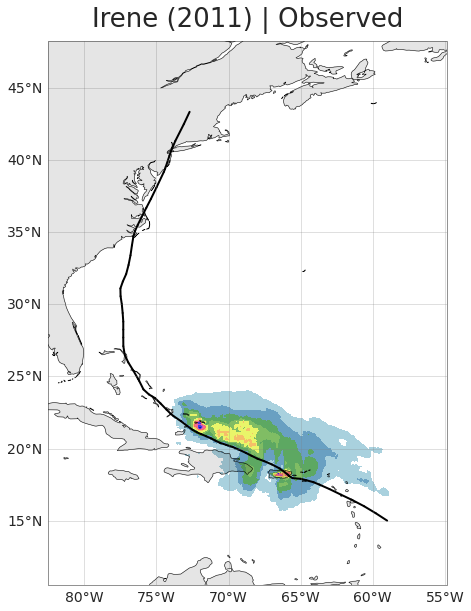

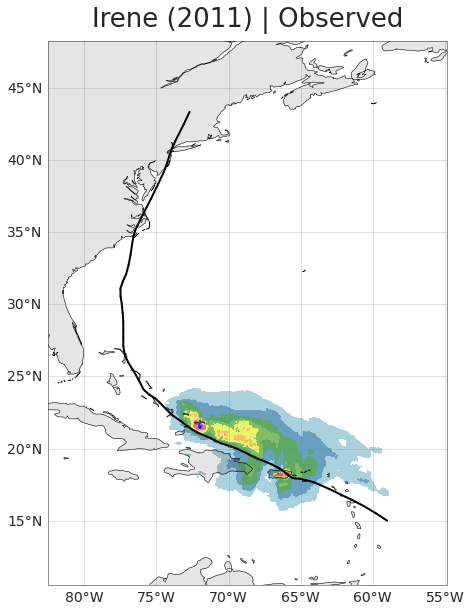

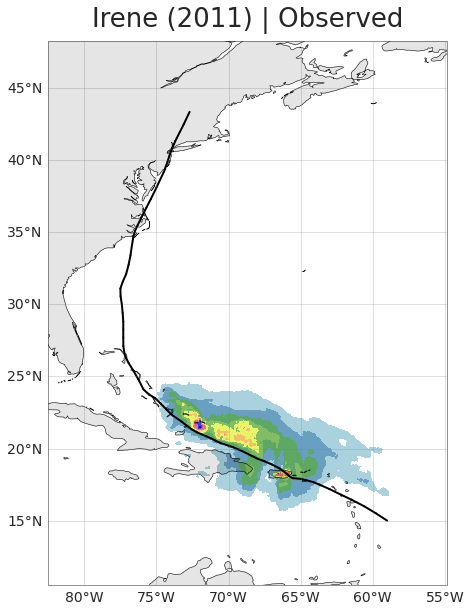

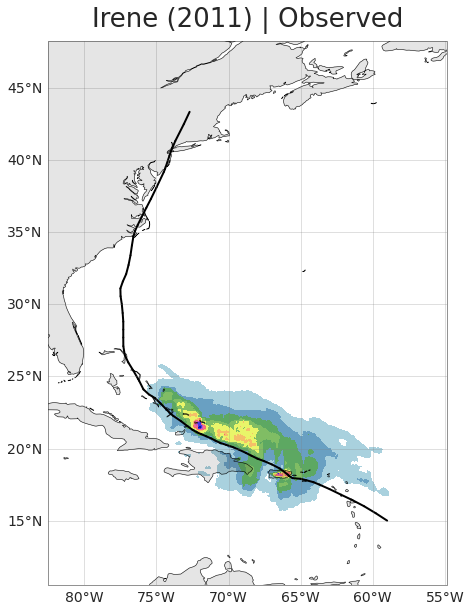

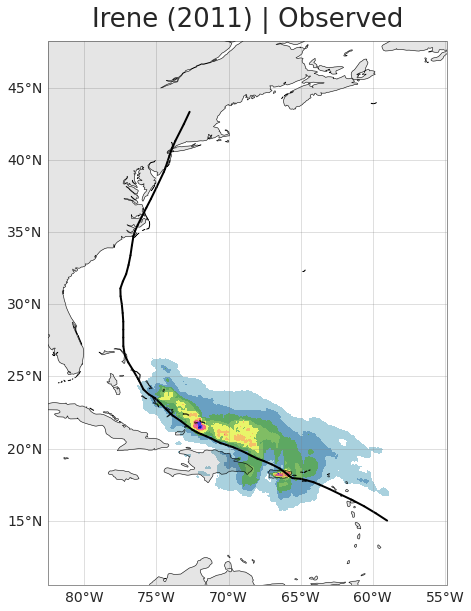

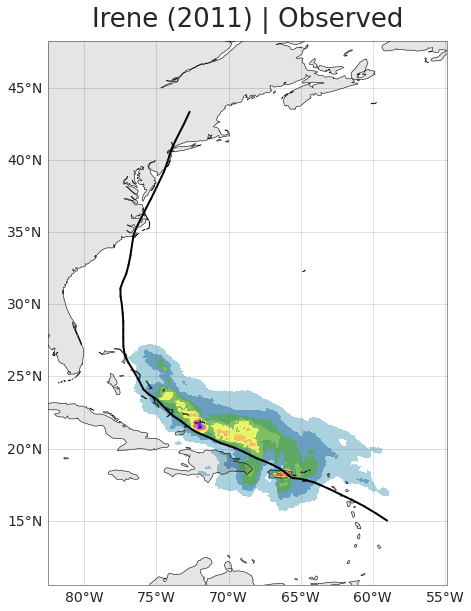

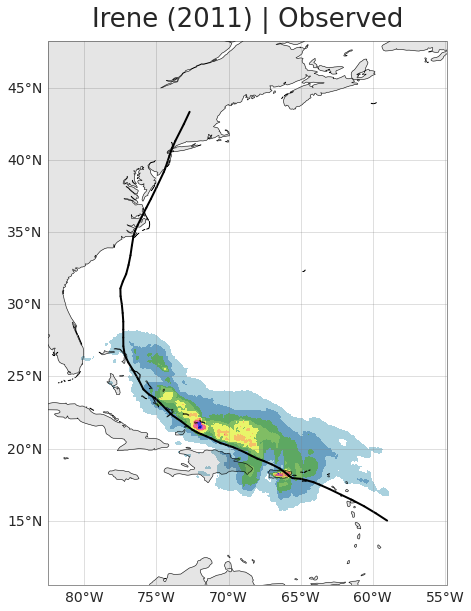

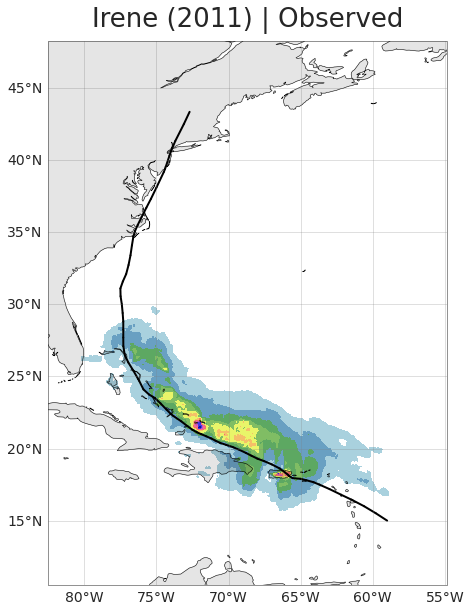

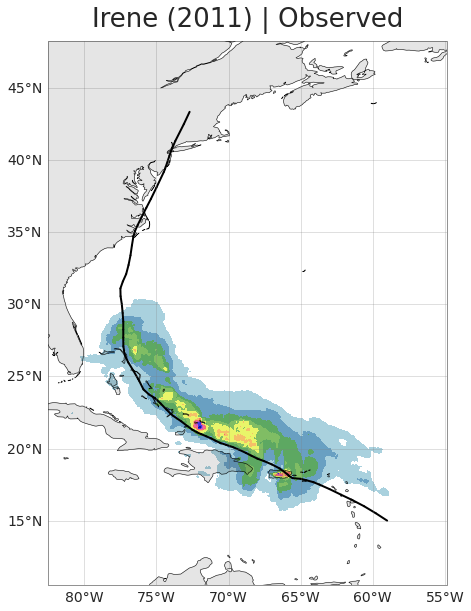

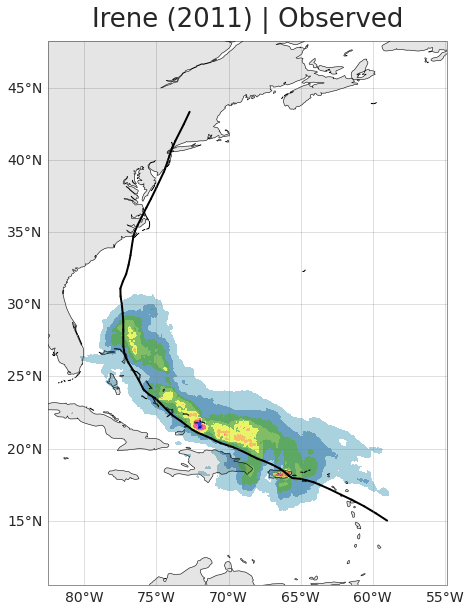

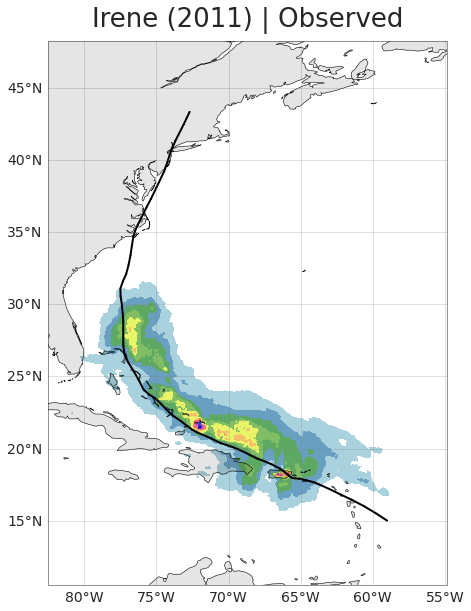

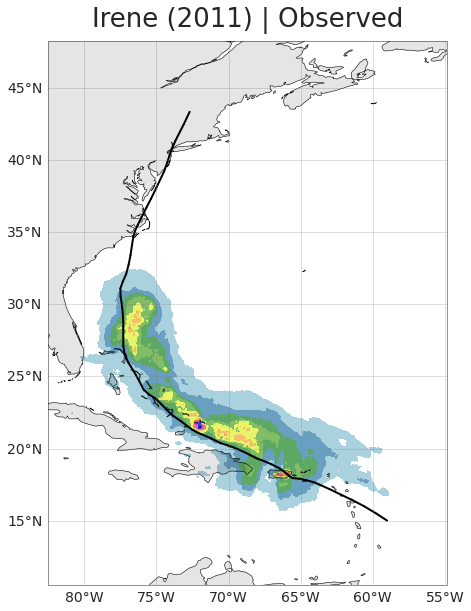

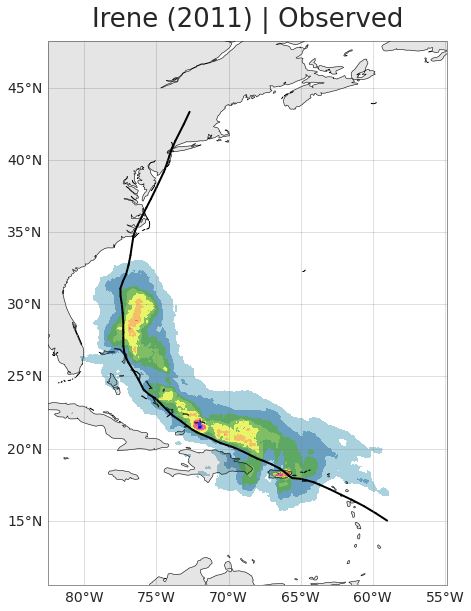

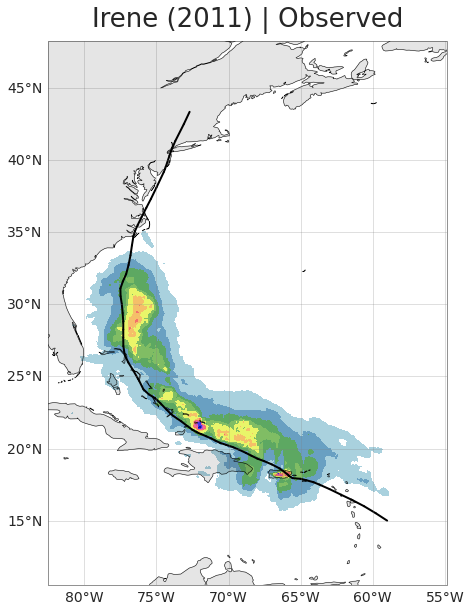

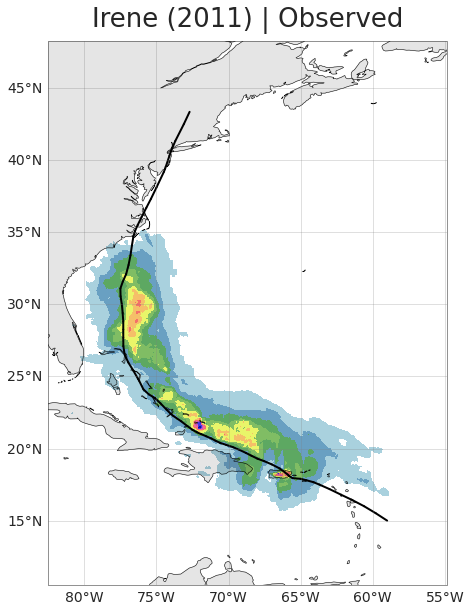

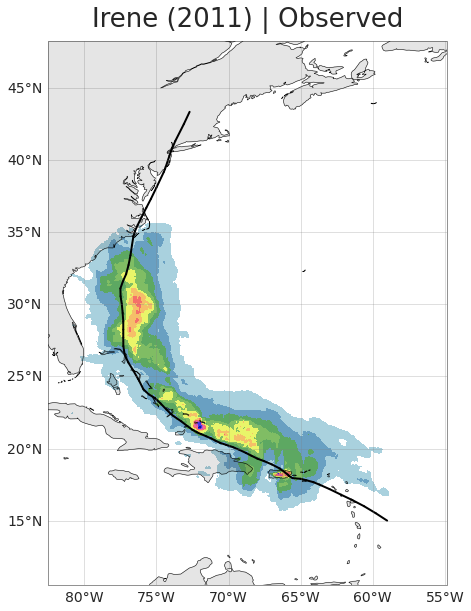

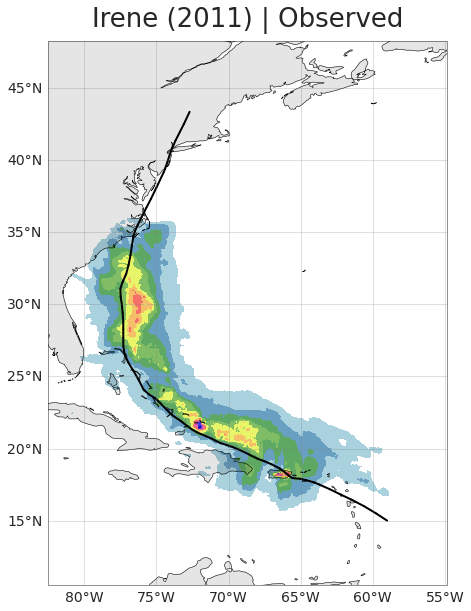

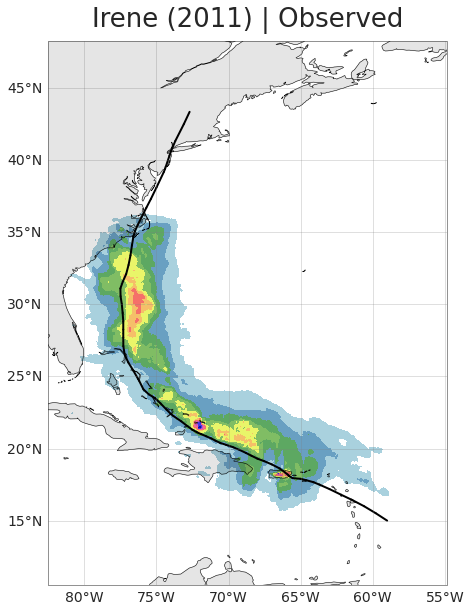

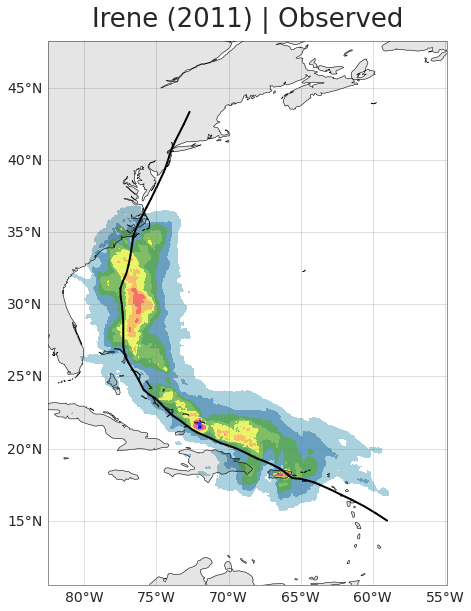

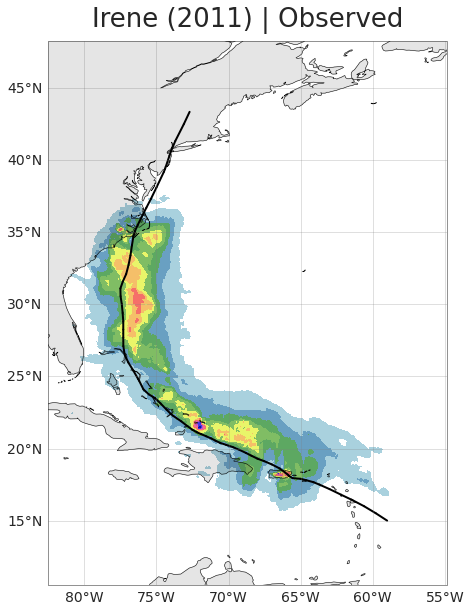

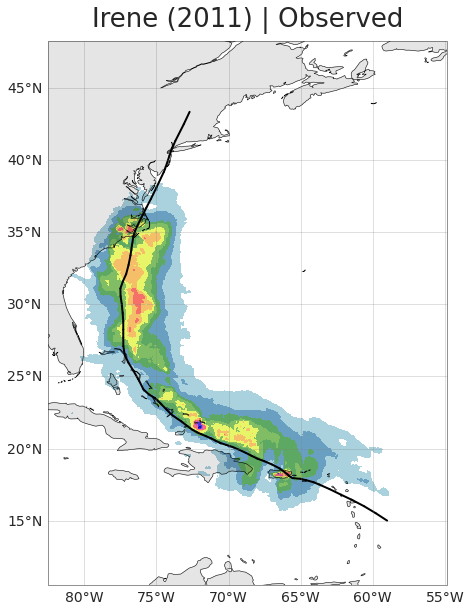

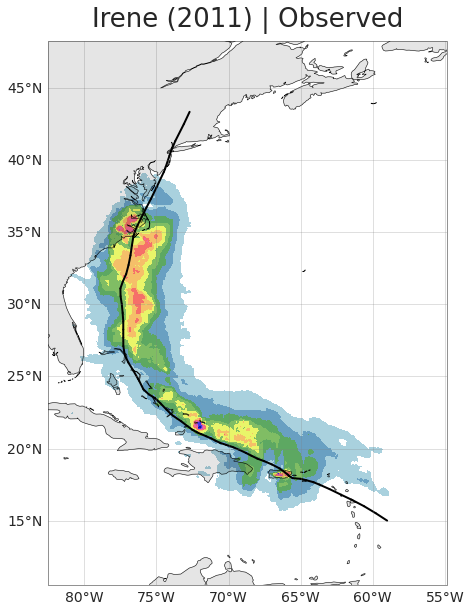

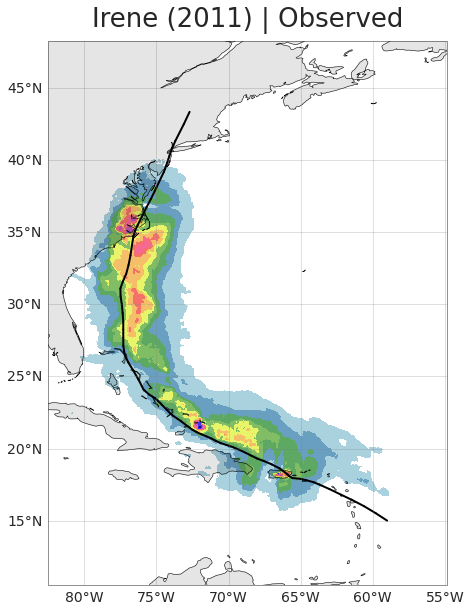

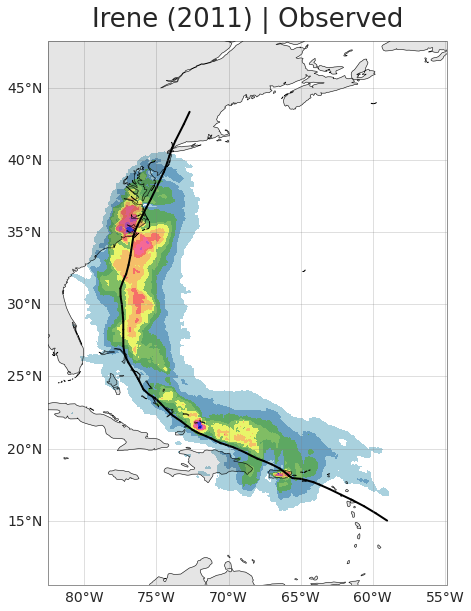

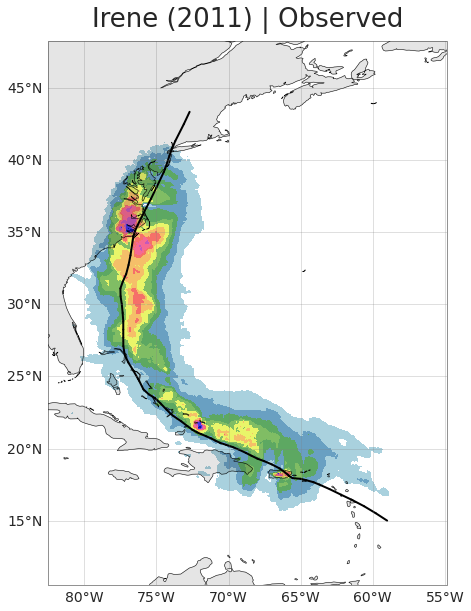

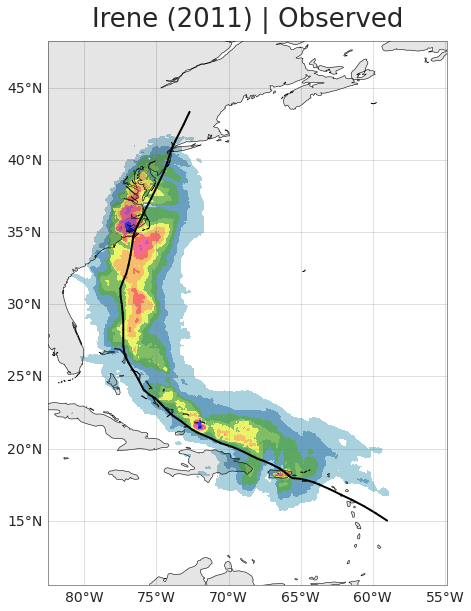

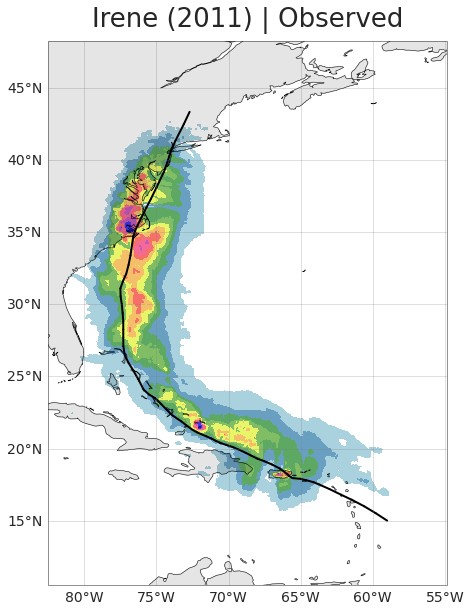

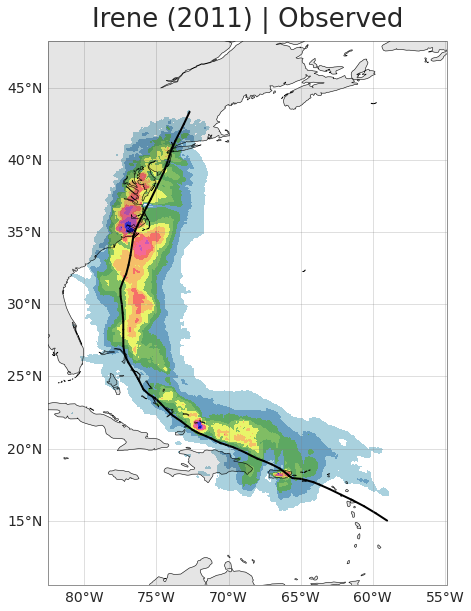

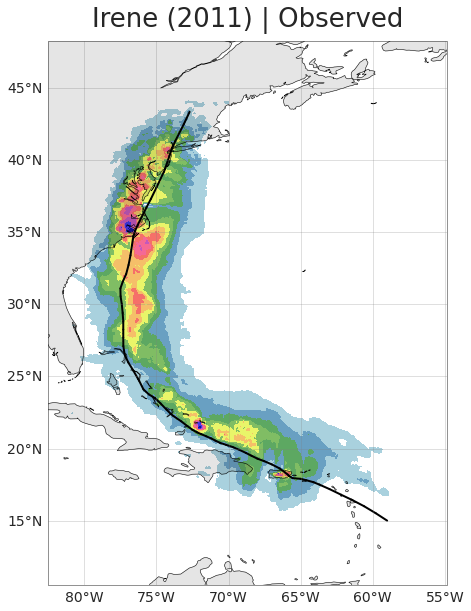

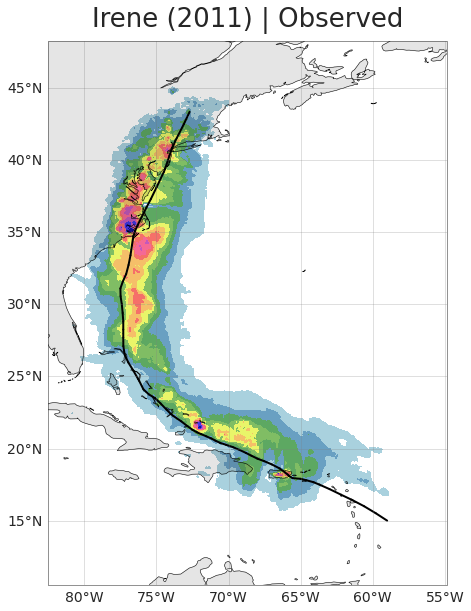

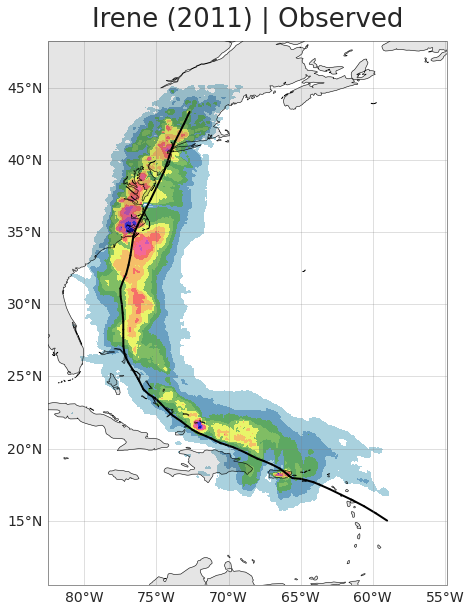

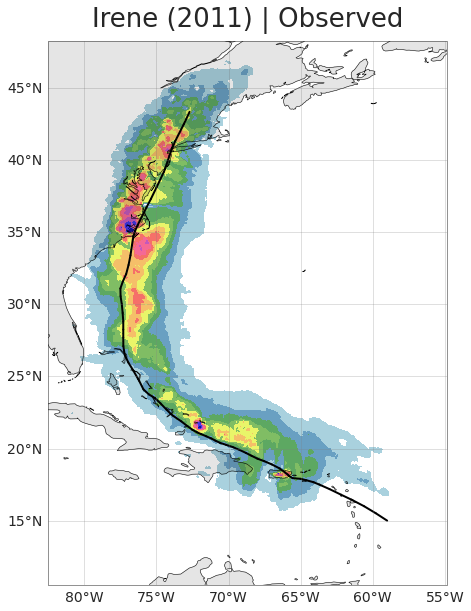

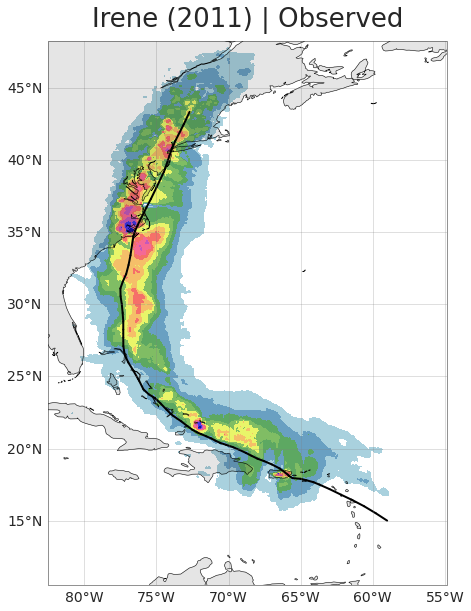

In [11]:
def create_frame():
	order = np.array(meta_irene['centre_lat']).argsort()
	# order = np.arange(0,len(meta_irene))
	print(order)
	meta_irene_sorted = meta_irene
	irene_real_sorted = irene_real[order,:,:]
	print(irene_real_sorted)
	meta_irene_sorted['centre_lon'] = np.array(meta_irene['centre_lon'])[order]
	meta_irene_sorted['centre_lat'] = np.array(meta_irene['centre_lat'])[order]
	print('index 1',meta_irene_sorted.index)
	meta_irene_sorted.index = meta_irene.index[order]
	meta_irene_sorted = meta_irene_sorted.reset_index()
	meta_irene_sorted = meta_irene_sorted.drop("index", axis=1)
	print('index 2',meta_irene_sorted.index)
	sid_sorted = sid_2011233N15301[order]
	for t in range(len(sid_2011233N15301)):
	# for t in range(5):
		accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_sorted,meta_irene_sorted,irene_real_sorted,irene_real_sorted,irene_inputs,t=t)
		levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
		sns.set_style("white")
		sns.set_context("notebook")
		precip_cmap,precip_norm = make_cmap()

		fig, axes = plt.subplots(1, 1, figsize=(15, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()})

		# Irene
		levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
		title = 'Irene (2011) | Observed'
		axes = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
									vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
									centre_lons=centre_lons_1,intensity=intensity_1,ax=axes,mask_oceans=True,title=title)

		plt.savefig('/user/home/al18709/work/figs/%s.png' % t,bbox_inches='tight',dpi=600)


create_frame()

In [12]:
# https://towardsdatascience.com/how-to-create-a-gif-from-matplotlib-plots-in-python-6bec6c0c952c
frames = []
for t in range(len(sid_2011233N15301)):
# for t in range(5):
    image = imageio.v2.imread(f'/user/home/al18709/work/figs/{t}.png')
    frames.append(image)
imageio.mimsave('example.gif', # output gif
                frames,          # array of input frames
                fps = 5)